In [1]:
pip install xgboost lightgbm catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/PS-S3/Ep7/train.csv'
file_key_2 = 'Tabular-Playground-Series/PS-S3/Ep7/test.csv'
file_key_3 = 'Tabular-Playground-Series/PS-S3/Ep7/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

## Fixing dates (https://www.kaggle.com/competitions/playground-series-s3e7/discussion/386655)
train['arrival_year_month'] = pd.to_datetime(train['arrival_year'].astype(str) + train['arrival_month'].astype(str), format = '%Y%m')
test['arrival_year_month'] = pd.to_datetime(test['arrival_year'].astype(str) + test['arrival_month'].astype(str), format = '%Y%m')

train.loc[train.arrival_date > train.arrival_year_month.dt.days_in_month, 'arrival_date'] = train.arrival_year_month.dt.days_in_month
test.loc[test.arrival_date > test.arrival_year_month.dt.days_in_month, 'arrival_date'] = test.arrival_year_month.dt.days_in_month

train.drop(columns = 'arrival_year_month', inplace = True)
test.drop(columns = 'arrival_year_month', inplace = True)

train['low_price_flag'] = np.where(train['avg_price_per_room'] < 30, 1, 0)
train['segment_0'] = np.where(train['market_segment_type'] == 0, 1, 0)
train['segment_1'] = np.where(train['market_segment_type'] == 1, 1, 0)
train['total_guests'] = train['no_of_adults'] + train['no_of_children']
train['stay_length'] = train['no_of_weekend_nights'] + train['no_of_week_nights']
train['stay_during_weekend'] = np.where(train['no_of_weekend_nights'] > 0, 1, 0)
train['quarter_1'] = np.where(train['arrival_month'] <= 3, 1, 0)
train['quarter_2'] = np.where(((train['arrival_month'] >= 4) & (train['arrival_month'] <= 6)), 1, 0)
train['quarter_3'] = np.where(((train['arrival_month'] >= 7) & (train['arrival_month'] <= 9)), 1, 0)
train['quarter_4'] = np.where(train['arrival_month'] >= 10, 1, 0)
train['segment_0_feature_1'] = np.where(((train['market_segment_type'] == 0) & (train['lead_time'] <= 90)), 1, 0)
train['segment_0_feature_2'] = np.where(((train['market_segment_type'] == 0) & (train['avg_price_per_room'] > 98)), 1, 0)
train['segment_1_feature_1'] = np.where(((train['market_segment_type'] == 1) & (train['no_of_special_requests'] == 0)), 1, 0)
train['segment_1_feature_2'] = np.where(((train['market_segment_type'] == 1) & (train['no_of_special_requests'] > 0) & (train['lead_time'] <= 150)), 1, 0)
train['segment_0_year_flag'] = np.where(((train['market_segment_type'] == 0) & (train['arrival_year'] == 2018)), 1, 0)
train['segment_1_year_flag'] = np.where(((train['market_segment_type'] == 1) & (train['arrival_year'] == 2018)), 1, 0)
train['price_lead_time_flag'] = np.where(((train['avg_price_per_room'] > 100) & (train['lead_time'] > 150)), 1, 0)

test['low_price_flag'] = np.where(test['avg_price_per_room'] < 30, 1, 0)
test['segment_0'] = np.where(test['market_segment_type'] == 0, 1, 0)
test['segment_1'] = np.where(test['market_segment_type'] == 1, 1, 0)
test['total_guests'] = test['no_of_adults'] + test['no_of_children']
test['stay_length'] = test['no_of_weekend_nights'] + test['no_of_week_nights']
test['stay_during_weekend'] = np.where(test['no_of_weekend_nights'] > 0, 1, 0)
test['quarter_1'] = np.where(test['arrival_month'] <= 3, 1, 0)
test['quarter_2'] = np.where(((test['arrival_month'] >= 4) & (test['arrival_month'] <= 6)), 1, 0)
test['quarter_3'] = np.where(((test['arrival_month'] >= 7) & (test['arrival_month'] <= 9)), 1, 0)
test['quarter_4'] = np.where(test['arrival_month'] >= 10, 1, 0)
test['segment_0_feature_1'] = np.where(((test['market_segment_type'] == 0) & (test['lead_time'] <= 90)), 1, 0)
test['segment_0_feature_2'] = np.where(((test['market_segment_type'] == 0) & (test['avg_price_per_room'] > 98)), 1, 0)
test['segment_1_feature_1'] = np.where(((test['market_segment_type'] == 1) & (test['no_of_special_requests'] == 0)), 1, 0)
test['segment_1_feature_2'] = np.where(((test['market_segment_type'] == 1) & (test['no_of_special_requests'] > 0) & (test['lead_time'] <= 150)), 1, 0)
test['segment_0_year_flag'] = np.where(((test['market_segment_type'] == 0) & (test['arrival_year'] == 2018)), 1, 0)
test['segment_1_year_flag'] = np.where(((test['market_segment_type'] == 1) & (test['arrival_year'] == 2018)), 1, 0)
test['price_lead_time_flag'] = np.where(((test['avg_price_per_room'] > 100) & (test['lead_time'] > 150)), 1, 0)

In [15]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,low_price_flag,segment_0,segment_1,total_guests,stay_length,stay_during_weekend,quarter_1,quarter_2,quarter_3,quarter_4,segment_0_feature_1,segment_0_feature_2,segment_1_feature_1,segment_1_feature_2,segment_0_year_flag,segment_1_year_flag,price_lead_time_flag
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,0,0,1,2,2,0,1,0,0,0,0,0,1,0,0,1,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,0,1,0,2,3,1,0,0,1,0,0,0,0,0,1,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,0,1,0,2,1,0,0,0,0,1,0,0,0,0,1,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,0,0,1,1,2,0,0,0,0,1,0,0,1,0,0,1,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,0,1,0,2,1,1,0,0,0,1,0,1,0,0,1,0,0


In [3]:
from sklearn.kernel_approximation import RBFSampler

X = train[['avg_price_per_room', 'lead_time']]

rbf_feature = RBFSampler(gamma = 1, random_state = 1)
A_features = rbf_feature.fit_transform(A)

In [4]:
A_features[:, 0:3]

array([[-0.09208778, -0.14120205, -0.13776265],
       [-0.14135896, -0.10259444, -0.0374632 ],
       [ 0.0645009 ,  0.14031746,  0.11619809],
       ...,
       [-0.12560176, -0.12282998,  0.02386545],
       [ 0.01417382,  0.06221048,  0.08961509],
       [-0.11265978, -0.11284745, -0.12549384]])

In [3]:
train_lgb = train.copy()
test_lgb = test.copy()

# X = train_lgb[['avg_price_per_room', 'lead_time', 'segment_0', 'segment_1', 'total_guests', 'stay_length', 'stay_during_weekend', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'segment_0_feature_1', 'segment_0_feature_2', 'segment_1_feature_1', 'segment_1_feature_2', 'segment_0_year_flag', 'segment_1_year_flag']]
# Y = train_lgb['booking_status']

# test_lgb = test_lgb[['avg_price_per_room', 'lead_time', 'segment_0', 'segment_1', 'total_guests', 'stay_length', 'stay_during_weekend', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'segment_0_feature_1', 'segment_0_feature_2', 'segment_1_feature_1', 'segment_1_feature_2', 'segment_0_year_flag', 'segment_1_year_flag']]

X = train_lgb[['avg_price_per_room', 'lead_time', 'total_guests', 'stay_length', 'segment_0_feature_1', 'segment_1_feature_1']]
Y = train_lgb['booking_status']

test_lgb = test_lgb[['avg_price_per_room', 'lead_time', 'total_guests', 'stay_length', 'segment_0_feature_1', 'segment_1_feature_1']]

# Optuna Optimization

In [5]:
class Objective:

    def __init__(self, seed):
        # Hold this implementation specific arguments as the fields of the class.
        self.seed = seed

    def __call__(self, trial):
        ## Parameters to be evaluated
        param = dict(objective = 'binary',
                     metric = 'auc',
                     tree_method = 'gbdt', 
                     n_estimators = trial.suggest_int('n_estimators', 300, 10000),
                     learning_rate = trial.suggest_float('learning_rate', 0.001, 1, log = True),
                     max_depth = trial.suggest_int('max_depth', 3, 12),
                     lambda_l1 = trial.suggest_float('lambda_l1', 0.01, 10.0, log = True),
                     lambda_l2 = trial.suggest_float('lambda_l2', 0.01, 10.0, log = True),
                     num_leaves = trial.suggest_int('num_leaves', 2, 100),
                     bagging_fraction = trial.suggest_float('bagging_fraction', 0.2, 0.9),
                     feature_fraction = trial.suggest_float('feature_fraction', 0.2, 0.9)
                    )

        scores = []
        
        skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = self.seed)
#         skf = KFold(n_splits = 5, shuffle = True, random_state = self.seed)

        for train_idx, valid_idx in skf.split(X, Y):

            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            Y_train , Y_valid = Y.iloc[train_idx] , Y.iloc[valid_idx]

            model = LGBMClassifier(**param).fit(X_train, Y_train)

#             preds_train = model.predict(X_train)
            preds_valid = model.predict_proba(X_valid)[:, 1]

            score = roc_auc_score(Y_valid, preds_valid)
            scores.append(score)

        return np.mean(scores)
    
## Defining number of runs and seed
RUNS = 2
SEED = 42
N_TRIALS = 50

# Execute an optimization
study = optuna.create_study(direction = 'maximize')
study.optimize(Objective(SEED), n_trials = N_TRIALS)

[I 2023-02-18 01:12:32,250] A new study created in memory with name: no-name-e811cfe6-1a19-4b8b-b44a-c43daa65f9d3


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.017365142572962827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017365142572962827
[LightGBM] [Warning] feature_fraction is set=0.5743331785994924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5743331785994924
[LightGBM] [Warning] lambda_l2 is set=0.040022476053902134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040022476053902134
[LightGBM] [Warning] bagging_fraction is set=0.49139074969910895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49139074969910895
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.017365142572962827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017365142572962827
[LightGBM] [Warning] feature_fraction is set=0.5743331785994924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5743331785994924
[LightGBM] [Warning] lambda

[I 2023-02-18 01:12:39,817] Trial 0 finished with value: 0.8617992816990068 and parameters: {'n_estimators': 1485, 'learning_rate': 0.004392325923268585, 'max_depth': 4, 'lambda_l1': 0.017365142572962827, 'lambda_l2': 0.040022476053902134, 'num_leaves': 99, 'bagging_fraction': 0.49139074969910895, 'feature_fraction': 0.5743331785994924}. Best is trial 0 with value: 0.8617992816990068.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.06415540093543508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06415540093543508
[LightGBM] [Warning] feature_fraction is set=0.7119489006715338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7119489006715338
[LightGBM] [Warning] lambda_l2 is set=1.873626295368181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.873626295368181
[LightGBM] [Warning] bagging_fraction is set=0.7720602241022945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7720602241022945
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.06415540093543508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06415540093543508
[LightGBM] [Warning] feature_fraction is set=0.7119489006715338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7119489006715338
[LightGBM] [Warning] lambda_l2 is set=1

[I 2023-02-18 01:12:59,232] Trial 1 finished with value: 0.8535446589163334 and parameters: {'n_estimators': 1726, 'learning_rate': 0.22224074041358613, 'max_depth': 10, 'lambda_l1': 0.06415540093543508, 'lambda_l2': 1.873626295368181, 'num_leaves': 84, 'bagging_fraction': 0.7720602241022945, 'feature_fraction': 0.7119489006715338}. Best is trial 0 with value: 0.8617992816990068.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.05313329482411561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05313329482411561
[LightGBM] [Warning] feature_fraction is set=0.4841692022737324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4841692022737324
[LightGBM] [Warning] lambda_l2 is set=5.57222065970239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.57222065970239
[LightGBM] [Warning] bagging_fraction is set=0.5497975367884808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5497975367884808
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.05313329482411561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05313329482411561
[LightGBM] [Warning] feature_fraction is set=0.4841692022737324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4841692022737324
[LightGBM] [Warning] lambda_l2 is set=5.5

[I 2023-02-18 01:13:32,152] Trial 2 finished with value: 0.8716195984359253 and parameters: {'n_estimators': 9862, 'learning_rate': 0.3106277691924472, 'max_depth': 3, 'lambda_l1': 0.05313329482411561, 'lambda_l2': 5.57222065970239, 'num_leaves': 52, 'bagging_fraction': 0.5497975367884808, 'feature_fraction': 0.4841692022737324}. Best is trial 2 with value: 0.8716195984359253.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.7341962555927137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7341962555927137
[LightGBM] [Warning] feature_fraction is set=0.6501096513041836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6501096513041836
[LightGBM] [Warning] lambda_l2 is set=0.0756941811739982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0756941811739982
[LightGBM] [Warning] bagging_fraction is set=0.2087207970442389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2087207970442389
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.7341962555927137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7341962555927137
[LightGBM] [Warning] feature_fraction is set=0.6501096513041836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6501096513041836
[LightGBM] [Warning] lambda_l2 is set=0.0

[I 2023-02-18 01:13:49,577] Trial 3 finished with value: 0.8779769061017149 and parameters: {'n_estimators': 3371, 'learning_rate': 0.008793192540589256, 'max_depth': 5, 'lambda_l1': 1.7341962555927137, 'lambda_l2': 0.0756941811739982, 'num_leaves': 23, 'bagging_fraction': 0.2087207970442389, 'feature_fraction': 0.6501096513041836}. Best is trial 3 with value: 0.8779769061017149.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.1081656458191644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1081656458191644
[LightGBM] [Warning] feature_fraction is set=0.8677678030949942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8677678030949942
[LightGBM] [Warning] lambda_l2 is set=0.19987677660123693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19987677660123693
[LightGBM] [Warning] bagging_fraction is set=0.5203469718851295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5203469718851295
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.1081656458191644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1081656458191644
[LightGBM] [Warning] feature_fraction is set=0.8677678030949942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8677678030949942
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-18 01:14:08,846] Trial 4 finished with value: 0.861981727720811 and parameters: {'n_estimators': 5865, 'learning_rate': 0.0018181688268905682, 'max_depth': 3, 'lambda_l1': 2.1081656458191644, 'lambda_l2': 0.19987677660123693, 'num_leaves': 66, 'bagging_fraction': 0.5203469718851295, 'feature_fraction': 0.8677678030949942}. Best is trial 3 with value: 0.8779769061017149.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=5.633327007584503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.633327007584503
[LightGBM] [Warning] feature_fraction is set=0.5744784667262228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5744784667262228
[LightGBM] [Warning] lambda_l2 is set=2.377433117883652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.377433117883652
[LightGBM] [Warning] bagging_fraction is set=0.8944770074030033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8944770074030033
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=5.633327007584503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.633327007584503
[LightGBM] [Warning] feature_fraction is set=0.5744784667262228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5744784667262228
[LightGBM] [Warning] lambda_l2 is set=2.3774331

[I 2023-02-18 01:15:53,705] Trial 5 finished with value: 0.8786610046467628 and parameters: {'n_estimators': 8335, 'learning_rate': 0.0024538349943457193, 'max_depth': 11, 'lambda_l1': 5.633327007584503, 'lambda_l2': 2.377433117883652, 'num_leaves': 81, 'bagging_fraction': 0.8944770074030033, 'feature_fraction': 0.5744784667262228}. Best is trial 5 with value: 0.8786610046467628.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.06632830032699859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06632830032699859
[LightGBM] [Warning] feature_fraction is set=0.7645179349483964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7645179349483964
[LightGBM] [Warning] lambda_l2 is set=0.024641938198824192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024641938198824192
[LightGBM] [Warning] bagging_fraction is set=0.7592733497818289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7592733497818289
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.06632830032699859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06632830032699859
[LightGBM] [Warning] feature_fraction is set=0.7645179349483964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7645179349483964
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-18 01:16:04,441] Trial 6 finished with value: 0.8728205764898627 and parameters: {'n_estimators': 4026, 'learning_rate': 0.01807313323185151, 'max_depth': 9, 'lambda_l1': 0.06632830032699859, 'lambda_l2': 0.024641938198824192, 'num_leaves': 4, 'bagging_fraction': 0.7592733497818289, 'feature_fraction': 0.7645179349483964}. Best is trial 5 with value: 0.8786610046467628.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.7199513713986909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7199513713986909
[LightGBM] [Warning] feature_fraction is set=0.5160658200570675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5160658200570675
[LightGBM] [Warning] lambda_l2 is set=0.06439452367445048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06439452367445048
[LightGBM] [Warning] bagging_fraction is set=0.8667992244153091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8667992244153091
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.7199513713986909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7199513713986909
[LightGBM] [Warning] feature_fraction is set=0.5160658200570675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5160658200570675
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-18 01:16:10,102] Trial 7 finished with value: 0.8691558404409282 and parameters: {'n_estimators': 666, 'learning_rate': 0.005844424438264885, 'max_depth': 12, 'lambda_l1': 0.7199513713986909, 'lambda_l2': 0.06439452367445048, 'num_leaves': 41, 'bagging_fraction': 0.8667992244153091, 'feature_fraction': 0.5160658200570675}. Best is trial 5 with value: 0.8786610046467628.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.15325528498054872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15325528498054872
[LightGBM] [Warning] feature_fraction is set=0.5044277802781603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044277802781603
[LightGBM] [Warning] lambda_l2 is set=1.586889730330633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.586889730330633
[LightGBM] [Warning] bagging_fraction is set=0.2105732671333269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2105732671333269
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.15325528498054872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15325528498054872
[LightGBM] [Warning] feature_fraction is set=0.5044277802781603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044277802781603
[LightGBM] [Warning] lambda_l2 is set=1

[I 2023-02-18 01:17:15,978] Trial 8 finished with value: 0.8375487284846731 and parameters: {'n_estimators': 7166, 'learning_rate': 0.36825233806817204, 'max_depth': 9, 'lambda_l1': 0.15325528498054872, 'lambda_l2': 1.586889730330633, 'num_leaves': 98, 'bagging_fraction': 0.2105732671333269, 'feature_fraction': 0.5044277802781603}. Best is trial 5 with value: 0.8786610046467628.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.11435862420140903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11435862420140903
[LightGBM] [Warning] feature_fraction is set=0.8773442915657423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8773442915657423
[LightGBM] [Warning] lambda_l2 is set=2.1915961658633236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1915961658633236
[LightGBM] [Warning] bagging_fraction is set=0.6095959416985095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6095959416985095
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.11435862420140903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11435862420140903
[LightGBM] [Warning] feature_fraction is set=0.8773442915657423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8773442915657423
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-18 01:19:07,507] Trial 9 finished with value: 0.8774321464764638 and parameters: {'n_estimators': 7286, 'learning_rate': 0.0012133468568382866, 'max_depth': 9, 'lambda_l1': 0.11435862420140903, 'lambda_l2': 2.1915961658633236, 'num_leaves': 100, 'bagging_fraction': 0.6095959416985095, 'feature_fraction': 0.8773442915657423}. Best is trial 5 with value: 0.8786610046467628.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=7.666374756202767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.666374756202767
[LightGBM] [Warning] feature_fraction is set=0.3136028688677623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3136028688677623
[LightGBM] [Warning] lambda_l2 is set=0.5387199664667816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5387199664667816
[LightGBM] [Warning] bagging_fraction is set=0.859013187743656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.859013187743656
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=7.666374756202767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.666374756202767
[LightGBM] [Warning] feature_fraction is set=0.3136028688677623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3136028688677623
[LightGBM] [Warning] lambda_l2 is set=0.5387199

[I 2023-02-18 01:19:30,956] Trial 10 finished with value: 0.8786673546565492 and parameters: {'n_estimators': 9879, 'learning_rate': 0.05351317381444934, 'max_depth': 12, 'lambda_l1': 7.666374756202767, 'lambda_l2': 0.5387199664667816, 'num_leaves': 71, 'bagging_fraction': 0.859013187743656, 'feature_fraction': 0.3136028688677623}. Best is trial 10 with value: 0.8786673546565492.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=9.316616594265916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.316616594265916
[LightGBM] [Warning] feature_fraction is set=0.3133263820916823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3133263820916823
[LightGBM] [Warning] lambda_l2 is set=0.4684637079800841, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4684637079800841
[LightGBM] [Warning] bagging_fraction is set=0.8934661973457532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8934661973457532
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=9.316616594265916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.316616594265916
[LightGBM] [Warning] feature_fraction is set=0.3133263820916823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3133263820916823
[LightGBM] [Warning] lambda_l2 is set=0.46846

[I 2023-02-18 01:19:52,787] Trial 11 finished with value: 0.87785352391478 and parameters: {'n_estimators': 9700, 'learning_rate': 0.05312538742830432, 'max_depth': 12, 'lambda_l1': 9.316616594265916, 'lambda_l2': 0.4684637079800841, 'num_leaves': 73, 'bagging_fraction': 0.8934661973457532, 'feature_fraction': 0.3133263820916823}. Best is trial 10 with value: 0.8786673546565492.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=8.82610077061852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.82610077061852
[LightGBM] [Warning] feature_fraction is set=0.22735789840688966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22735789840688966
[LightGBM] [Warning] lambda_l2 is set=9.377982713062993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.377982713062993
[LightGBM] [Warning] bagging_fraction is set=0.8829653816315906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8829653816315906
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=8.82610077061852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.82610077061852
[LightGBM] [Warning] feature_fraction is set=0.22735789840688966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22735789840688966
[LightGBM] [Warning] lambda_l2 is set=9.3779827

[I 2023-02-18 01:20:22,318] Trial 12 finished with value: 0.8683532195372881 and parameters: {'n_estimators': 8162, 'learning_rate': 0.061702575692629436, 'max_depth': 11, 'lambda_l1': 8.82610077061852, 'lambda_l2': 9.377982713062993, 'num_leaves': 68, 'bagging_fraction': 0.8829653816315906, 'feature_fraction': 0.22735789840688966}. Best is trial 10 with value: 0.8786673546565492.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=3.8993443655844273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8993443655844273
[LightGBM] [Warning] feature_fraction is set=0.377655496027735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.377655496027735
[LightGBM] [Warning] lambda_l2 is set=0.7185404490342936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7185404490342936
[LightGBM] [Warning] bagging_fraction is set=0.7709055034119853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7709055034119853
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=3.8993443655844273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8993443655844273
[LightGBM] [Warning] feature_fraction is set=0.377655496027735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.377655496027735
[LightGBM] [Warning] lambda_l2 is set=0.71854

[I 2023-02-18 01:20:56,840] Trial 13 finished with value: 0.8796507652041372 and parameters: {'n_estimators': 8675, 'learning_rate': 0.023930112078531424, 'max_depth': 7, 'lambda_l1': 3.8993443655844273, 'lambda_l2': 0.7185404490342936, 'num_leaves': 50, 'bagging_fraction': 0.7709055034119853, 'feature_fraction': 0.377655496027735}. Best is trial 13 with value: 0.8796507652041372.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=3.0174369814595674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0174369814595674
[LightGBM] [Warning] feature_fraction is set=0.36961010223018836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36961010223018836
[LightGBM] [Warning] lambda_l2 is set=0.5394372405862566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5394372405862566
[LightGBM] [Warning] bagging_fraction is set=0.7415086616236497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415086616236497
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=3.0174369814595674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0174369814595674
[LightGBM] [Warning] feature_fraction is set=0.36961010223018836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36961010223018836
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-18 01:21:25,909] Trial 14 finished with value: 0.8797499823669934 and parameters: {'n_estimators': 8816, 'learning_rate': 0.025730523173758922, 'max_depth': 6, 'lambda_l1': 3.0174369814595674, 'lambda_l2': 0.5394372405862566, 'num_leaves': 49, 'bagging_fraction': 0.7415086616236497, 'feature_fraction': 0.36961010223018836}. Best is trial 14 with value: 0.8797499823669934.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.615516807221776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.615516807221776
[LightGBM] [Warning] feature_fraction is set=0.41842962367286657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41842962367286657
[LightGBM] [Warning] lambda_l2 is set=0.25263414011282664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25263414011282664
[LightGBM] [Warning] bagging_fraction is set=0.6981456769750092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6981456769750092
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.615516807221776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.615516807221776
[LightGBM] [Warning] feature_fraction is set=0.41842962367286657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41842962367286657
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-18 01:21:58,813] Trial 15 finished with value: 0.8797665602949942 and parameters: {'n_estimators': 5597, 'learning_rate': 0.012385540159500861, 'max_depth': 6, 'lambda_l1': 0.615516807221776, 'lambda_l2': 0.25263414011282664, 'num_leaves': 36, 'bagging_fraction': 0.6981456769750092, 'feature_fraction': 0.41842962367286657}. Best is trial 15 with value: 0.8797665602949942.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.5886578430261418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5886578430261418
[LightGBM] [Warning] feature_fraction is set=0.4302567376006638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4302567376006638
[LightGBM] [Warning] lambda_l2 is set=0.011039024174471588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011039024174471588
[LightGBM] [Warning] bagging_fraction is set=0.6814778272276306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814778272276306
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.5886578430261418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5886578430261418
[LightGBM] [Warning] feature_fraction is set=0.4302567376006638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4302567376006638
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-18 01:22:30,340] Trial 16 finished with value: 0.879404249647215 and parameters: {'n_estimators': 5570, 'learning_rate': 0.014153117398994157, 'max_depth': 6, 'lambda_l1': 0.5886578430261418, 'lambda_l2': 0.011039024174471588, 'num_leaves': 32, 'bagging_fraction': 0.6814778272276306, 'feature_fraction': 0.4302567376006638}. Best is trial 15 with value: 0.8797665602949942.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.8236628575893714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8236628575893714
[LightGBM] [Warning] feature_fraction is set=0.3947419055938031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3947419055938031
[LightGBM] [Warning] lambda_l2 is set=0.21735927620463882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21735927620463882
[LightGBM] [Warning] bagging_fraction is set=0.663935620029347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.663935620029347
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.8236628575893714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8236628575893714
[LightGBM] [Warning] feature_fraction is set=0.3947419055938031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3947419055938031
[LightGBM] [Warning] lambda_l2 is set=0.2

[I 2023-02-18 01:22:46,162] Trial 17 finished with value: 0.8748707993317802 and parameters: {'n_estimators': 4108, 'learning_rate': 0.009798675217906557, 'max_depth': 7, 'lambda_l1': 0.8236628575893714, 'lambda_l2': 0.21735927620463882, 'num_leaves': 12, 'bagging_fraction': 0.663935620029347, 'feature_fraction': 0.3947419055938031}. Best is trial 15 with value: 0.8797665602949942.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.371520497835062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.371520497835062
[LightGBM] [Warning] feature_fraction is set=0.2525700623588395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2525700623588395
[LightGBM] [Warning] lambda_l2 is set=0.12967195160265604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12967195160265604
[LightGBM] [Warning] bagging_fraction is set=0.6943970499025456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6943970499025456
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.371520497835062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.371520497835062
[LightGBM] [Warning] feature_fraction is set=0.2525700623588395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2525700623588395
[LightGBM] [Warning] lambda_l2 is set=0.129

[I 2023-02-18 01:23:12,968] Trial 18 finished with value: 0.8749949472322595 and parameters: {'n_estimators': 6663, 'learning_rate': 0.10678093106030657, 'max_depth': 5, 'lambda_l1': 0.371520497835062, 'lambda_l2': 0.12967195160265604, 'num_leaves': 56, 'bagging_fraction': 0.6943970499025456, 'feature_fraction': 0.2525700623588395}. Best is trial 15 with value: 0.8797665602949942.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.9883731579665989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9883731579665989
[LightGBM] [Warning] feature_fraction is set=0.41324286285928297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41324286285928297
[LightGBM] [Warning] lambda_l2 is set=0.33213569506370055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33213569506370055
[LightGBM] [Warning] bagging_fraction is set=0.6038228666219781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6038228666219781
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.9883731579665989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9883731579665989
[LightGBM] [Warning] feature_fraction is set=0.41324286285928297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41324286285928297
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-18 01:23:37,815] Trial 19 finished with value: 0.8797348541431781 and parameters: {'n_estimators': 4524, 'learning_rate': 0.025631976781748913, 'max_depth': 6, 'lambda_l1': 1.9883731579665989, 'lambda_l2': 0.33213569506370055, 'num_leaves': 31, 'bagging_fraction': 0.6038228666219781, 'feature_fraction': 0.41324286285928297}. Best is trial 15 with value: 0.8797665602949942.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.2519982987199818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2519982987199818
[LightGBM] [Warning] feature_fraction is set=0.20799249175856166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20799249175856166
[LightGBM] [Warning] lambda_l2 is set=0.927513843004557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.927513843004557
[LightGBM] [Warning] bagging_fraction is set=0.4518040994617665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4518040994617665
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.2519982987199818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2519982987199818
[LightGBM] [Warning] feature_fraction is set=0.20799249175856166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20799249175856166
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-18 01:23:49,521] Trial 20 finished with value: 0.8656220677452833 and parameters: {'n_estimators': 2637, 'learning_rate': 0.004678672819143013, 'max_depth': 8, 'lambda_l1': 1.2519982987199818, 'lambda_l2': 0.927513843004557, 'num_leaves': 40, 'bagging_fraction': 0.4518040994617665, 'feature_fraction': 0.20799249175856166}. Best is trial 15 with value: 0.8797665602949942.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=3.098314851301947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.098314851301947
[LightGBM] [Warning] feature_fraction is set=0.4398234957466449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4398234957466449
[LightGBM] [Warning] lambda_l2 is set=0.35607052412947615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35607052412947615
[LightGBM] [Warning] bagging_fraction is set=0.6011411302456305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6011411302456305
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=3.098314851301947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.098314851301947
[LightGBM] [Warning] feature_fraction is set=0.4398234957466449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4398234957466449
[LightGBM] [Warning] lambda_l2 is set=0.356

[I 2023-02-18 01:24:09,534] Trial 21 finished with value: 0.8797311136345369 and parameters: {'n_estimators': 4768, 'learning_rate': 0.025560615111587928, 'max_depth': 6, 'lambda_l1': 3.098314851301947, 'lambda_l2': 0.35607052412947615, 'num_leaves': 27, 'bagging_fraction': 0.6011411302456305, 'feature_fraction': 0.4398234957466449}. Best is trial 15 with value: 0.8797665602949942.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.706284412656167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.706284412656167
[LightGBM] [Warning] feature_fraction is set=0.36460271954223983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36460271954223983
[LightGBM] [Warning] lambda_l2 is set=0.2735343186140223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2735343186140223
[LightGBM] [Warning] bagging_fraction is set=0.621374517127666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.621374517127666
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.706284412656167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.706284412656167
[LightGBM] [Warning] feature_fraction is set=0.36460271954223983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36460271954223983
[LightGBM] [Warning] lambda_l2 is set=0.273

[I 2023-02-18 01:24:31,670] Trial 22 finished with value: 0.8793340216574347 and parameters: {'n_estimators': 6234, 'learning_rate': 0.029671500444026312, 'max_depth': 6, 'lambda_l1': 2.706284412656167, 'lambda_l2': 0.2735343186140223, 'num_leaves': 17, 'bagging_fraction': 0.621374517127666, 'feature_fraction': 0.36460271954223983}. Best is trial 15 with value: 0.8797665602949942.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.0941892853898922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0941892853898922
[LightGBM] [Warning] feature_fraction is set=0.44924399311133834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44924399311133834
[LightGBM] [Warning] lambda_l2 is set=0.12407316945599041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12407316945599041
[LightGBM] [Warning] bagging_fraction is set=0.7186511645808942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7186511645808942
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.0941892853898922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0941892853898922
[LightGBM] [Warning] feature_fraction is set=0.44924399311133834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44924399311133834
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-18 01:24:56,241] Trial 23 finished with value: 0.8798641702750569 and parameters: {'n_estimators': 4940, 'learning_rate': 0.01572774872291263, 'max_depth': 5, 'lambda_l1': 1.0941892853898922, 'lambda_l2': 0.12407316945599041, 'num_leaves': 38, 'bagging_fraction': 0.7186511645808942, 'feature_fraction': 0.44924399311133834}. Best is trial 23 with value: 0.8798641702750569.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.1681273158613699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1681273158613699
[LightGBM] [Warning] feature_fraction is set=0.31774063096740474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31774063096740474
[LightGBM] [Warning] lambda_l2 is set=0.15041010378564662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15041010378564662
[LightGBM] [Warning] bagging_fraction is set=0.8087099707053436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8087099707053436
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.1681273158613699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1681273158613699
[LightGBM] [Warning] feature_fraction is set=0.31774063096740474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31774063096740474
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-18 01:25:19,557] Trial 24 finished with value: 0.8782991413934056 and parameters: {'n_estimators': 5306, 'learning_rate': 0.011225207919113474, 'max_depth': 5, 'lambda_l1': 1.1681273158613699, 'lambda_l2': 0.15041010378564662, 'num_leaves': 44, 'bagging_fraction': 0.8087099707053436, 'feature_fraction': 0.31774063096740474}. Best is trial 23 with value: 0.8798641702750569.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.3995810443490194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3995810443490194
[LightGBM] [Warning] feature_fraction is set=0.49646376222989874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49646376222989874
[LightGBM] [Warning] lambda_l2 is set=0.1287494409653726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1287494409653726
[LightGBM] [Warning] bagging_fraction is set=0.7223423608977475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7223423608977475
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.3995810443490194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3995810443490194
[LightGBM] [Warning] feature_fraction is set=0.49646376222989874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49646376222989874
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-18 01:25:31,351] Trial 25 finished with value: 0.8769178390403646 and parameters: {'n_estimators': 2862, 'learning_rate': 0.015507352476072668, 'max_depth': 4, 'lambda_l1': 0.3995810443490194, 'lambda_l2': 0.1287494409653726, 'num_leaves': 59, 'bagging_fraction': 0.7223423608977475, 'feature_fraction': 0.49646376222989874}. Best is trial 23 with value: 0.8798641702750569.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=4.559699010861208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.559699010861208
[LightGBM] [Warning] feature_fraction is set=0.4531833153089554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4531833153089554
[LightGBM] [Warning] lambda_l2 is set=0.856415324287532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.856415324287532
[LightGBM] [Warning] bagging_fraction is set=0.8115054255934423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115054255934423
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=4.559699010861208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.559699010861208
[LightGBM] [Warning] feature_fraction is set=0.4531833153089554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4531833153089554
[LightGBM] [Warning] lambda_l2 is set=0.8564153

[I 2023-02-18 01:25:50,703] Trial 26 finished with value: 0.8779683582165998 and parameters: {'n_estimators': 7569, 'learning_rate': 0.038452014369802785, 'max_depth': 4, 'lambda_l1': 4.559699010861208, 'lambda_l2': 0.856415324287532, 'num_leaves': 34, 'bagging_fraction': 0.8115054255934423, 'feature_fraction': 0.4531833153089554}. Best is trial 23 with value: 0.8798641702750569.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.0703559093536126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0703559093536126
[LightGBM] [Warning] feature_fraction is set=0.3584080615910963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3584080615910963
[LightGBM] [Warning] lambda_l2 is set=0.09394701567472458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09394701567472458
[LightGBM] [Warning] bagging_fraction is set=0.7181183604835871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7181183604835871
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.0703559093536126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0703559093536126
[LightGBM] [Warning] feature_fraction is set=0.3584080615910963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3584080615910963
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-18 01:26:05,593] Trial 27 finished with value: 0.8757576356799046 and parameters: {'n_estimators': 9066, 'learning_rate': 0.698413733559317, 'max_depth': 7, 'lambda_l1': 1.0703559093536126, 'lambda_l2': 0.09394701567472458, 'num_leaves': 47, 'bagging_fraction': 0.7181183604835871, 'feature_fraction': 0.3584080615910963}. Best is trial 23 with value: 0.8798641702750569.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.4759410065221577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4759410065221577
[LightGBM] [Warning] feature_fraction is set=0.5490225340154232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5490225340154232
[LightGBM] [Warning] lambda_l2 is set=0.24110787659633862, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.24110787659633862
[LightGBM] [Warning] bagging_fraction is set=0.7389960956473522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7389960956473522
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.4759410065221577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4759410065221577
[LightGBM] [Warning] feature_fraction is set=0.5490225340154232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5490225340154232
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-18 01:26:40,791] Trial 28 finished with value: 0.8797193865452686 and parameters: {'n_estimators': 3549, 'learning_rate': 0.008587219158089148, 'max_depth': 8, 'lambda_l1': 0.4759410065221577, 'lambda_l2': 0.24110787659633862, 'num_leaves': 59, 'bagging_fraction': 0.7389960956473522, 'feature_fraction': 0.5490225340154232}. Best is trial 23 with value: 0.8798641702750569.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.24674072177771508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24674072177771508
[LightGBM] [Warning] feature_fraction is set=0.45669172336381747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45669172336381747
[LightGBM] [Warning] lambda_l2 is set=0.03947070799610886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03947070799610886
[LightGBM] [Warning] bagging_fraction is set=0.8129004267201299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8129004267201299
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.24674072177771508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24674072177771508
[LightGBM] [Warning] feature_fraction is set=0.45669172336381747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45669172336381747
[LightGBM] [Warning] lambda_l2 

[I 2023-02-18 01:27:12,806] Trial 29 finished with value: 0.8789664544102379 and parameters: {'n_estimators': 6685, 'learning_rate': 0.016063100761057682, 'max_depth': 5, 'lambda_l1': 0.24674072177771508, 'lambda_l2': 0.03947070799610886, 'num_leaves': 23, 'bagging_fraction': 0.8129004267201299, 'feature_fraction': 0.45669172336381747}. Best is trial 23 with value: 0.8798641702750569.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.3747710334200887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3747710334200887
[LightGBM] [Warning] feature_fraction is set=0.26606541328503264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26606541328503264
[LightGBM] [Warning] lambda_l2 is set=0.4459007519736046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4459007519736046
[LightGBM] [Warning] bagging_fraction is set=0.6699176783908217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6699176783908217
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.3747710334200887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3747710334200887
[LightGBM] [Warning] feature_fraction is set=0.26606541328503264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26606541328503264
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-18 01:27:42,359] Trial 30 finished with value: 0.8728909778238538 and parameters: {'n_estimators': 7776, 'learning_rate': 0.0038346540388240575, 'max_depth': 4, 'lambda_l1': 1.3747710334200887, 'lambda_l2': 0.4459007519736046, 'num_leaves': 40, 'bagging_fraction': 0.6699176783908217, 'feature_fraction': 0.26606541328503264}. Best is trial 23 with value: 0.8798641702750569.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.2979621376415658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2979621376415658
[LightGBM] [Warning] feature_fraction is set=0.40953811680971003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40953811680971003
[LightGBM] [Warning] lambda_l2 is set=0.340160093877836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.340160093877836
[LightGBM] [Warning] bagging_fraction is set=0.6347793937923804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6347793937923804
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.2979621376415658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2979621376415658
[LightGBM] [Warning] feature_fraction is set=0.40953811680971003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40953811680971003
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-18 01:28:01,539] Trial 31 finished with value: 0.8798873483567503 and parameters: {'n_estimators': 4633, 'learning_rate': 0.0342734530852348, 'max_depth': 6, 'lambda_l1': 2.2979621376415658, 'lambda_l2': 0.340160093877836, 'num_leaves': 33, 'bagging_fraction': 0.6347793937923804, 'feature_fraction': 0.40953811680971003}. Best is trial 31 with value: 0.8798873483567503.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.5929896373077144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5929896373077144
[LightGBM] [Warning] feature_fraction is set=0.41953292008518117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41953292008518117
[LightGBM] [Warning] lambda_l2 is set=0.1757014734845128, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1757014734845128
[LightGBM] [Warning] bagging_fraction is set=0.7201887491722135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7201887491722135
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.5929896373077144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5929896373077144
[LightGBM] [Warning] feature_fraction is set=0.41953292008518117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41953292008518117
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-18 01:28:18,138] Trial 32 finished with value: 0.8799903985410327 and parameters: {'n_estimators': 4820, 'learning_rate': 0.04216438731098924, 'max_depth': 6, 'lambda_l1': 2.5929896373077144, 'lambda_l2': 0.1757014734845128, 'num_leaves': 36, 'bagging_fraction': 0.7201887491722135, 'feature_fraction': 0.41953292008518117}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.9432815414214539, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9432815414214539
[LightGBM] [Warning] feature_fraction is set=0.4176148467666032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4176148467666032
[LightGBM] [Warning] lambda_l2 is set=0.18028714940810192, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18028714940810192
[LightGBM] [Warning] bagging_fraction is set=0.6747153015934702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6747153015934702
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.9432815414214539, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9432815414214539
[LightGBM] [Warning] feature_fraction is set=0.4176148467666032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4176148467666032
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-18 01:28:38,685] Trial 33 finished with value: 0.8769885694390671 and parameters: {'n_estimators': 5138, 'learning_rate': 0.08282301846360852, 'max_depth': 5, 'lambda_l1': 0.9432815414214539, 'lambda_l2': 0.18028714940810192, 'num_leaves': 36, 'bagging_fraction': 0.6747153015934702, 'feature_fraction': 0.4176148467666032}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.8432463045434375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8432463045434375
[LightGBM] [Warning] feature_fraction is set=0.46419269986881967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46419269986881967
[LightGBM] [Warning] lambda_l2 is set=0.09848812339846214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09848812339846214
[LightGBM] [Warning] bagging_fraction is set=0.6492103819329006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6492103819329006
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.8432463045434375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8432463045434375
[LightGBM] [Warning] feature_fraction is set=0.46419269986881967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46419269986881967
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-18 01:28:58,795] Trial 34 finished with value: 0.8796377926683487 and parameters: {'n_estimators': 4905, 'learning_rate': 0.04429424535939506, 'max_depth': 7, 'lambda_l1': 1.8432463045434375, 'lambda_l2': 0.09848812339846214, 'num_leaves': 18, 'bagging_fraction': 0.6492103819329006, 'feature_fraction': 0.46419269986881967}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.6374025876049179, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6374025876049179
[LightGBM] [Warning] feature_fraction is set=0.5409782194302304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5409782194302304
[LightGBM] [Warning] lambda_l2 is set=0.27754073977949445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27754073977949445
[LightGBM] [Warning] bagging_fraction is set=0.5634990130828318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5634990130828318
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.6374025876049179, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6374025876049179
[LightGBM] [Warning] feature_fraction is set=0.5409782194302304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5409782194302304
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-18 01:29:24,386] Trial 35 finished with value: 0.8722327098744949 and parameters: {'n_estimators': 6050, 'learning_rate': 0.1305094727219258, 'max_depth': 5, 'lambda_l1': 0.6374025876049179, 'lambda_l2': 0.27754073977949445, 'num_leaves': 30, 'bagging_fraction': 0.5634990130828318, 'feature_fraction': 0.5409782194302304}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.181009464500437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.181009464500437
[LightGBM] [Warning] feature_fraction is set=0.5931586485274941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5931586485274941
[LightGBM] [Warning] lambda_l2 is set=0.17387128781851294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17387128781851294
[LightGBM] [Warning] bagging_fraction is set=0.7222923639145082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7222923639145082
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.181009464500437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.181009464500437
[LightGBM] [Warning] feature_fraction is set=0.5931586485274941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5931586485274941
[LightGBM] [Warning] lambda_l2 is set=0.173

[I 2023-02-18 01:29:42,116] Trial 36 finished with value: 0.8793384610181361 and parameters: {'n_estimators': 4230, 'learning_rate': 0.04000291876053239, 'max_depth': 3, 'lambda_l1': 2.181009464500437, 'lambda_l2': 0.17387128781851294, 'num_leaves': 23, 'bagging_fraction': 0.7222923639145082, 'feature_fraction': 0.5931586485274941}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.499490453266863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.499490453266863
[LightGBM] [Warning] feature_fraction is set=0.4704374441375907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4704374441375907
[LightGBM] [Warning] lambda_l2 is set=0.06694401663714826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06694401663714826
[LightGBM] [Warning] bagging_fraction is set=0.7868758267629419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7868758267629419
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.499490453266863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.499490453266863
[LightGBM] [Warning] feature_fraction is set=0.4704374441375907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4704374441375907
[LightGBM] [Warning] lambda_l2 is set=0.066

[I 2023-02-18 01:29:49,526] Trial 37 finished with value: 0.8666156807957346 and parameters: {'n_estimators': 1903, 'learning_rate': 0.007628536154924719, 'max_depth': 8, 'lambda_l1': 1.499490453266863, 'lambda_l2': 0.06694401663714826, 'num_leaves': 8, 'bagging_fraction': 0.7868758267629419, 'feature_fraction': 0.4704374441375907}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=5.749754551361519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.749754551361519
[LightGBM] [Warning] feature_fraction is set=0.40663920498888334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40663920498888334
[LightGBM] [Warning] lambda_l2 is set=0.11767017676773107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11767017676773107
[LightGBM] [Warning] bagging_fraction is set=0.7023280918593248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7023280918593248
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=5.749754551361519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.749754551361519
[LightGBM] [Warning] feature_fraction is set=0.40663920498888334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40663920498888334
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-18 01:30:06,657] Trial 38 finished with value: 0.8777278872251711 and parameters: {'n_estimators': 3326, 'learning_rate': 0.01671594045934826, 'max_depth': 6, 'lambda_l1': 5.749754551361519, 'lambda_l2': 0.11767017676773107, 'num_leaves': 54, 'bagging_fraction': 0.7023280918593248, 'feature_fraction': 0.40663920498888334}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.8902287045577321, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8902287045577321
[LightGBM] [Warning] feature_fraction is set=0.49227596981749644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49227596981749644
[LightGBM] [Warning] lambda_l2 is set=0.17169465789632596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17169465789632596
[LightGBM] [Warning] bagging_fraction is set=0.6548577227424864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6548577227424864
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.8902287045577321, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8902287045577321
[LightGBM] [Warning] feature_fraction is set=0.49227596981749644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49227596981749644
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-18 01:30:29,672] Trial 39 finished with value: 0.879261767820498 and parameters: {'n_estimators': 5608, 'learning_rate': 0.03266737887431659, 'max_depth': 4, 'lambda_l1': 0.8902287045577321, 'lambda_l2': 0.17169465789632596, 'num_leaves': 36, 'bagging_fraction': 0.6548577227424864, 'feature_fraction': 0.49227596981749644}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.5209085617899447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5209085617899447
[LightGBM] [Warning] feature_fraction is set=0.5951740906848806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951740906848806
[LightGBM] [Warning] lambda_l2 is set=0.3400101620088194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3400101620088194
[LightGBM] [Warning] bagging_fraction is set=0.7669910848204917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7669910848204917
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.5209085617899447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5209085617899447
[LightGBM] [Warning] feature_fraction is set=0.5951740906848806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951740906848806
[LightGBM] [Warning] lambda_l2 is set=0.3

[I 2023-02-18 01:30:42,389] Trial 40 finished with value: 0.8692311421527567 and parameters: {'n_estimators': 3826, 'learning_rate': 0.006216672710824509, 'max_depth': 3, 'lambda_l1': 1.5209085617899447, 'lambda_l2': 0.3400101620088194, 'num_leaves': 25, 'bagging_fraction': 0.7669910848204917, 'feature_fraction': 0.5951740906848806}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.6272645884006396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6272645884006396
[LightGBM] [Warning] feature_fraction is set=0.35752686073745665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35752686073745665
[LightGBM] [Warning] lambda_l2 is set=0.5942940761562872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5942940761562872
[LightGBM] [Warning] bagging_fraction is set=0.7261608337902107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7261608337902107
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.6272645884006396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6272645884006396
[LightGBM] [Warning] feature_fraction is set=0.35752686073745665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35752686073745665
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-18 01:31:12,161] Trial 41 finished with value: 0.8797413926681686 and parameters: {'n_estimators': 6497, 'learning_rate': 0.01999878622509115, 'max_depth': 6, 'lambda_l1': 2.6272645884006396, 'lambda_l2': 0.5942940761562872, 'num_leaves': 45, 'bagging_fraction': 0.7261608337902107, 'feature_fraction': 0.35752686073745665}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=3.034340674728303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.034340674728303
[LightGBM] [Warning] feature_fraction is set=0.394624962503795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.394624962503795
[LightGBM] [Warning] lambda_l2 is set=0.2518887979654267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2518887979654267
[LightGBM] [Warning] bagging_fraction is set=0.7483412527953331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7483412527953331
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=3.034340674728303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.034340674728303
[LightGBM] [Warning] feature_fraction is set=0.394624962503795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.394624962503795
[LightGBM] [Warning] lambda_l2 is set=0.251888797

[I 2023-02-18 01:31:38,784] Trial 42 finished with value: 0.8794407208296511 and parameters: {'n_estimators': 4512, 'learning_rate': 0.011957056712401723, 'max_depth': 7, 'lambda_l1': 3.034340674728303, 'lambda_l2': 0.2518887979654267, 'num_leaves': 50, 'bagging_fraction': 0.7483412527953331, 'feature_fraction': 0.394624962503795}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=4.167887507542184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.167887507542184
[LightGBM] [Warning] feature_fraction is set=0.4378097495537269, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4378097495537269
[LightGBM] [Warning] lambda_l2 is set=0.4156813001465508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4156813001465508
[LightGBM] [Warning] bagging_fraction is set=0.7015678903727189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7015678903727189
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=4.167887507542184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.167887507542184
[LightGBM] [Warning] feature_fraction is set=0.4378097495537269, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4378097495537269
[LightGBM] [Warning] lambda_l2 is set=0.41568

[I 2023-02-18 01:31:41,295] Trial 43 finished with value: 0.867524697672493 and parameters: {'n_estimators': 310, 'learning_rate': 0.021707514059740658, 'max_depth': 6, 'lambda_l1': 4.167887507542184, 'lambda_l2': 0.4156813001465508, 'num_leaves': 39, 'bagging_fraction': 0.7015678903727189, 'feature_fraction': 0.4378097495537269}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.9957611175493672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9957611175493672
[LightGBM] [Warning] feature_fraction is set=0.5170098264691622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5170098264691622
[LightGBM] [Warning] lambda_l2 is set=1.1004219354398568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1004219354398568
[LightGBM] [Warning] bagging_fraction is set=0.7463008000557249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7463008000557249
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.9957611175493672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9957611175493672
[LightGBM] [Warning] feature_fraction is set=0.5170098264691622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5170098264691622
[LightGBM] [Warning] lambda_l2 is set=1.1

[I 2023-02-18 01:31:56,106] Trial 44 finished with value: 0.8799753850606938 and parameters: {'n_estimators': 3009, 'learning_rate': 0.033103891145550755, 'max_depth': 5, 'lambda_l1': 1.9957611175493672, 'lambda_l2': 1.1004219354398568, 'num_leaves': 45, 'bagging_fraction': 0.7463008000557249, 'feature_fraction': 0.5170098264691622}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.6734023247735077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6734023247735077
[LightGBM] [Warning] feature_fraction is set=0.5191221119344678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5191221119344678
[LightGBM] [Warning] lambda_l2 is set=3.56090054976849, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.56090054976849
[LightGBM] [Warning] bagging_fraction is set=0.7920841973331978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7920841973331978
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.6734023247735077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6734023247735077
[LightGBM] [Warning] feature_fraction is set=0.5191221119344678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5191221119344678
[LightGBM] [Warning] lambda_l2 is set=3.56090

[I 2023-02-18 01:32:07,503] Trial 45 finished with value: 0.8796668356396713 and parameters: {'n_estimators': 2371, 'learning_rate': 0.06654073181946439, 'max_depth': 5, 'lambda_l1': 1.6734023247735077, 'lambda_l2': 3.56090054976849, 'num_leaves': 44, 'bagging_fraction': 0.7920841973331978, 'feature_fraction': 0.5191221119344678}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.7045259340633371, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7045259340633371
[LightGBM] [Warning] feature_fraction is set=0.519589692252544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519589692252544
[LightGBM] [Warning] lambda_l2 is set=1.1982049730229958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1982049730229958
[LightGBM] [Warning] bagging_fraction is set=0.8372546208251451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8372546208251451
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.7045259340633371, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7045259340633371
[LightGBM] [Warning] feature_fraction is set=0.519589692252544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519589692252544
[LightGBM] [Warning] lambda_l2 is set=1.19820

[I 2023-02-18 01:32:20,837] Trial 46 finished with value: 0.8793590221180692 and parameters: {'n_estimators': 3224, 'learning_rate': 0.03559478955185014, 'max_depth': 4, 'lambda_l1': 0.7045259340633371, 'lambda_l2': 1.1982049730229958, 'num_leaves': 18, 'bagging_fraction': 0.8372546208251451, 'feature_fraction': 0.519589692252544}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.250018552318756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.250018552318756
[LightGBM] [Warning] feature_fraction is set=0.4673473335316989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4673473335316989
[LightGBM] [Warning] lambda_l2 is set=1.3860275348091307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3860275348091307
[LightGBM] [Warning] bagging_fraction is set=0.7536114609528467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7536114609528467
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=2.250018552318756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.250018552318756
[LightGBM] [Warning] feature_fraction is set=0.4673473335316989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4673473335316989
[LightGBM] [Warning] lambda_l2 is set=1.38602

[I 2023-02-18 01:32:29,093] Trial 47 finished with value: 0.8797219745674294 and parameters: {'n_estimators': 1604, 'learning_rate': 0.048469786646959244, 'max_depth': 5, 'lambda_l1': 2.250018552318756, 'lambda_l2': 1.3860275348091307, 'num_leaves': 28, 'bagging_fraction': 0.7536114609528467, 'feature_fraction': 0.4673473335316989}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.110895420905404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.110895420905404
[LightGBM] [Warning] feature_fraction is set=0.4879671187004857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4879671187004857
[LightGBM] [Warning] lambda_l2 is set=0.7099180618367555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7099180618367555
[LightGBM] [Warning] bagging_fraction is set=0.6348809313433122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6348809313433122
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.110895420905404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.110895420905404
[LightGBM] [Warning] feature_fraction is set=0.4879671187004857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4879671187004857
[LightGBM] [Warning] lambda_l2 is set=0.70991

[I 2023-02-18 01:33:17,950] Trial 48 finished with value: 0.8793852666019719 and parameters: {'n_estimators': 5634, 'learning_rate': 0.01186322702948798, 'max_depth': 7, 'lambda_l1': 1.110895420905404, 'lambda_l2': 0.7099180618367555, 'num_leaves': 93, 'bagging_fraction': 0.6348809313433122, 'feature_fraction': 0.4879671187004857}. Best is trial 32 with value: 0.8799903985410327.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=6.462642444637475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.462642444637475
[LightGBM] [Warning] feature_fraction is set=0.6289757980632213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289757980632213
[LightGBM] [Warning] lambda_l2 is set=0.20308804266979827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20308804266979827
[LightGBM] [Warning] bagging_fraction is set=0.8408001876475771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8408001876475771
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=6.462642444637475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.462642444637475
[LightGBM] [Warning] feature_fraction is set=0.6289757980632213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289757980632213
[LightGBM] [Warning] lambda_l2 is set=0.203

[I 2023-02-18 01:33:35,079] Trial 49 finished with value: 0.8778465738349984 and parameters: {'n_estimators': 3846, 'learning_rate': 0.01973767239963651, 'max_depth': 6, 'lambda_l1': 6.462642444637475, 'lambda_l2': 0.20308804266979827, 'num_leaves': 36, 'bagging_fraction': 0.8408001876475771, 'feature_fraction': 0.6289757980632213}. Best is trial 32 with value: 0.8799903985410327.


In [9]:
study.best_trial.values

[0.8799903985410327]

In [6]:
study.best_trial.params

{'n_estimators': 4820,
 'learning_rate': 0.04216438731098924,
 'max_depth': 6,
 'lambda_l1': 2.5929896373077144,
 'lambda_l2': 0.1757014734845128,
 'num_leaves': 36,
 'bagging_fraction': 0.7201887491722135,
 'feature_fraction': 0.41953292008518117}

# Cross Validation

In [10]:
cv_scores, roc_auc_scores = list(), list()
lgb_imp, preds = list(), list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 4820,
                                max_depth = 6,
                                learning_rate = 0.04216438731098924,
                                num_leaves = 36,
                                lambda_l1 = 2.5929896373077144,
                                lambda_l2 = 0.1757014734845128,
                                bagging_fraction = 0.7201887491722135,
                                feature_fraction = 0.41953292008518117).fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test_lgb)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

lgb_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

# 0.8794706067469678
# 0.8799903985410327

[LightGBM] [Warning] lambda_l1 is set=2.5929896373077144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5929896373077144
[LightGBM] [Warning] feature_fraction is set=0.41953292008518117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41953292008518117
[LightGBM] [Warning] lambda_l2 is set=0.1757014734845128, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1757014734845128
[LightGBM] [Warning] bagging_fraction is set=0.7201887491722135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7201887491722135
[LightGBM] [Warning] lambda_l1 is set=2.5929896373077144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5929896373077144
[LightGBM] [Warning] feature_fraction is set=0.41953292008518117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41953292008518117
[LightGBM] [Warning] lambda_l2 is set=0.1757014734845128, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1757014734845128
[LightG

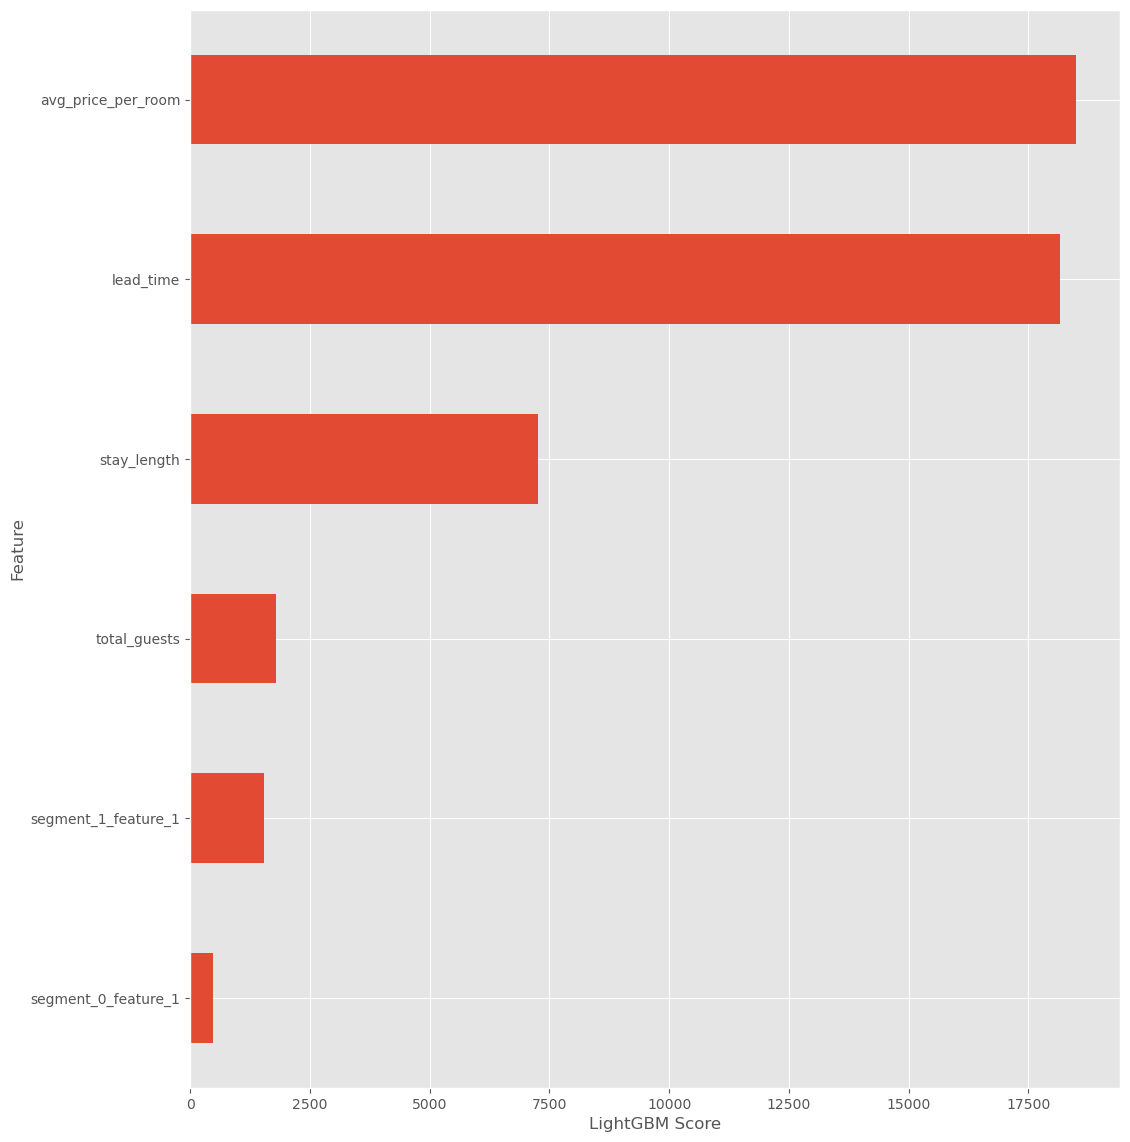

In [11]:
plt.figure(figsize = (12, 14))
pd.DataFrame(lgb_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('LightGBM Score')
plt.ylabel('Feature')
plt.show();

In [12]:
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['booking_status'] = lgb_preds_test
submission.head()

,id,booking_status
0,42100,0.212082
1,42101,0.282103
2,42102,0.151508
3,42103,0.032877
4,42104,0.498930


In [13]:
submission.to_csv('LightGBM_6_features__optuna_submission.csv', index = False)